# Figure 3E

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
from scipy.optimize import curve_fit
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Function to define the properties of the axis of a plot

In [2]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

Function to plot together the exp data and the model predictions for the different cell types

In [3]:
def plot_celltypes(data_exp, data_model, error, col, axs, avg=True): 
    
    mean_data_exp = np.nanmean(data_exp)
    mean_data_model = np.nanmean(data_model)
    std_data_exp = np.nanstd(data_exp)
    
    x = np.random.normal(1, 0.08, size=len(data_exp))
    axs.plot(x,data_exp,'.', color= col, alpha=0.3, markersize=10, zorder=1) 
     
    x = np.random.normal(2, 0.08, size=len(data_model))
    axs.plot(x,data_model,'.', color= col, alpha=0.3, markersize=10, zorder=1)
    
    if avg==True:
        x = 1 
        axs.errorbar(x,mean_data_exp ,std_data_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)
   
        x = 2 
        axs.errorbar(x,mean_data_model ,error, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

Evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T)

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

Evolution equation for the activator Ap

In [8]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=12,Er_v=0.5,KMM3_v=0.05,vMM4_v=1,KMM4_v=0.05):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [9]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=12,Er_v=0.5,KMM1_v=0.05,vMM2_v=1,KMM2_v=0.05): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [10]:
expr_Otx = vb+ vo*Ap/((Ka*(1+I/Ki))+Ap)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Import the experimental data 

In [11]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig3E = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Fig 3E')
df_Fig3E = pd.DataFrame(data_Fig3E)

Experimental data figure 1C 

In [12]:
# Reltive area of cell surface contact with FGF expressing cells (divided by cell type)
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

Experimental data figure 3E

In [13]:
# Levels of Otx expression - ctrl 
Otx_a65 = np.array(df_Fig3E['a6.5msxMO'].values.tolist())
Otx_a66 = np.array(df_Fig3E['a6.6msxMO'].values.tolist())
Otx_a67 = np.array(df_Fig3E['a6.7msxMO'].values.tolist())
Otx_a68 = np.array(df_Fig3E['a6.8msxMO'].values.tolist())

# Levels of Otx expression - ERF morpholino 
Otx_a65_ErfMO = np.array(df_Fig3E['a6.5ERF2-MO'].values.tolist())
Otx_a66_ErfMO = np.array(df_Fig3E['a6.6ERF2-MO'].values.tolist())
Otx_a67_ErfMO = np.array(df_Fig3E['a6.7ERF2-MO'].values.tolist())
Otx_a68_ErfMO = np.array(df_Fig3E['a6.8ERF2-MO'].values.tolist())

alldataOtx = np.concatenate((Otx_a65, Otx_a66, Otx_a67, Otx_a68))
alldataOtx_ErfMO = np.concatenate((Otx_a65_ErfMO, Otx_a66_ErfMO, Otx_a67_ErfMO, Otx_a68_ErfMO))

alldataOtx = [alldataOtx[i] for i in range(len(alldataOtx)) if np.isnan(alldataOtx[i]) == False]
alldataOtx_ErfMO = [alldataOtx_ErfMO[i] for i in range(len(alldataOtx_ErfMO)) if np.isnan(alldataOtx_ErfMO[i]) == False]

In [14]:
# Compute mean and std of the experimental data 

# Cntrl
mean_Otx_65 = np.nanmean(Otx_a65)
mean_Otx_66 = np.nanmean(Otx_a66)
mean_Otx_67 = np.nanmean(Otx_a67)
mean_Otx_68 = np.nanmean(Otx_a68)

std_Otx_65 = np.nanstd(Otx_a65)
std_Otx_66 = np.nanstd(Otx_a66)
std_Otx_67 = np.nanstd(Otx_a67)
std_Otx_68 = np.nanstd(Otx_a68)

# ERF morpholino
mean_Otx_ERFmo_65 = np.nanmean(Otx_a65_ErfMO)
mean_Otx_ERFmo_66 = np.nanmean(Otx_a66_ErfMO)
mean_Otx_ERFmo_67 = np.nanmean(Otx_a67_ErfMO)
mean_Otx_ERFmo_68 = np.nanmean(Otx_a68_ErfMO)

std_Otx_ERFmo_65 = np.nanstd(Otx_a65_ErfMO)
std_Otx_ERFmo_66 = np.nanstd(Otx_a66_ErfMO)
std_Otx_ERFmo_67 = np.nanstd(Otx_a67_ErfMO)
std_Otx_ERFmo_68 = np.nanstd(Otx_a68_ErfMO)

# Results

## Figure 3E


### Model predictions

In [15]:
# Compute T
T_pred_ERFmo_65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_ERFmo_66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_ERFmo_67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_ERFmo_68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk activity 
Erk_pred_ERFmo_65 = Erk(T_pred_ERFmo_65)
Erk_pred_ERFmo_66 = Erk(T_pred_ERFmo_66)
Erk_pred_ERFmo_67 = Erk(T_pred_ERFmo_67)
Erk_pred_ERFmo_68 = Erk(T_pred_ERFmo_68)

# Compute Ap
Ap_pred_ERFmo_65 = [exprAp(Er_v=Erk_pred_ERFmo_65[i]) for i in range(len(Erk_pred_ERFmo_65))]
Ap_pred_ERFmo_66 = [exprAp(Er_v=Erk_pred_ERFmo_66[i]) for i in range(len(Erk_pred_ERFmo_66))]
Ap_pred_ERFmo_67 = [exprAp(Er_v=Erk_pred_ERFmo_67[i]) for i in range(len(Erk_pred_ERFmo_67))]
Ap_pred_ERFmo_68 = [exprAp(Er_v=Erk_pred_ERFmo_68[i]) for i in range(len(Erk_pred_ERFmo_68))]

# Compute I 
I_pred_ERFmo_65= 0.001 * np.ones(len(Erk_pred_ERFmo_65))
I_pred_ERFmo_66= 0.001 * np.ones(len(Erk_pred_ERFmo_66))
I_pred_ERFmo_67= 0.001 * np.ones(len(Erk_pred_ERFmo_67))
I_pred_ERFmo_68= 0.001 * np.ones(len(Erk_pred_ERFmo_68))

# Compute Otx expression
Otx_pred_ERFmo_65_e = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_65,I_v=I_pred_ERFmo_65)).astype(float)
Otx_pred_ERFmo_66_e = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_66,I_v=I_pred_ERFmo_66)).astype(float)
Otx_pred_ERFmo_67_e = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_67,I_v=I_pred_ERFmo_67)).astype(float)
Otx_pred_ERFmo_68_e = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_68,I_v=I_pred_ERFmo_68)).astype(float)

mean_Otx_pred_ERFmo_65_e = np.mean(Otx_pred_ERFmo_65_e)
mean_Otx_pred_ERFmo_66_e = np.mean(Otx_pred_ERFmo_66_e)
mean_Otx_pred_ERFmo_67_e = np.mean(Otx_pred_ERFmo_67_e)
mean_Otx_pred_ERFmo_68_e = np.mean(Otx_pred_ERFmo_68_e)

std_Otx_pred_ERFmo_65_e = np.nanstd(Otx_pred_ERFmo_65_e)
std_Otx_pred_ERFmo_66_e = np.nanstd(Otx_pred_ERFmo_66_e)
std_Otx_pred_ERFmo_67_e = np.nanstd(Otx_pred_ERFmo_67_e)
std_Otx_pred_ERFmo_68_e = np.nanstd(Otx_pred_ERFmo_68_e)

In [16]:
# Compute Otx spot counts
Omax_value= 75
Obas_value= mean_Otx_ERFmo_68

Otx_pred_ERFmo_65_sc = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_65,I_v=I_pred_ERFmo_65, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_ERFmo_66_sc = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_66,I_v=I_pred_ERFmo_66, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_ERFmo_67_sc = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_67,I_v=I_pred_ERFmo_67, Omax= Omax_value,Obas=Obas_value)).astype(float)
Otx_pred_ERFmo_68_sc = np.array(exprOtx(Ap_v=Ap_pred_ERFmo_68,I_v=I_pred_ERFmo_68, Omax= Omax_value,Obas=Obas_value)).astype(float)

mean_Otx_pred_ERFmo_65_sc = np.mean(Otx_pred_ERFmo_65_sc)
mean_Otx_pred_ERFmo_66_sc = np.mean(Otx_pred_ERFmo_66_sc)
mean_Otx_pred_ERFmo_67_sc = np.mean(Otx_pred_ERFmo_67_sc)
mean_Otx_pred_ERFmo_68_sc = np.mean(Otx_pred_ERFmo_68_sc)

std_Otx_pred_ERFmo_65_sc = np.sqrt(Omax_value**2*std_Otx_pred_ERFmo_65_e**2+std_Otx_ERFmo_68**2)
std_Otx_pred_ERFmo_66_sc = np.sqrt(Omax_value**2*std_Otx_pred_ERFmo_66_e**2+std_Otx_ERFmo_68**2)
std_Otx_pred_ERFmo_67_sc = np.sqrt(Omax_value**2*std_Otx_pred_ERFmo_67_e**2+std_Otx_ERFmo_68**2)
std_Otx_pred_ERFmo_68_sc = np.sqrt(Omax_value**2*std_Otx_pred_ERFmo_68_e**2+std_Otx_ERFmo_68**2)

### Comparison with the experimental data 

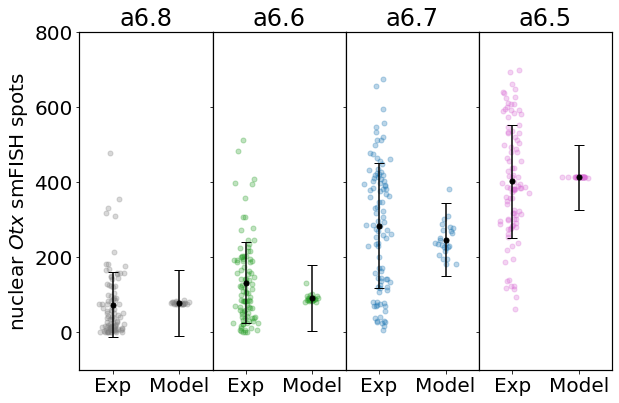

In [17]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8 
ax = axs[0]
plot_celltypes(Otx_a68_ErfMO, Otx_pred_ERFmo_68_sc,std_Otx_pred_ERFmo_68_sc, col='grey', axs=ax, avg=True)
ax.set_ylabel('nuclear $Otx$ smFISH spots')
my_axsis(ax, xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.8', xtickslabels=['Exp', 'Model'])

# a6.6 
ax = axs[1]
plot_celltypes(Otx_a66_ErfMO, Otx_pred_ERFmo_66_sc,std_Otx_pred_ERFmo_66_sc, col='tab:green', axs=ax, avg=True)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'])

# a6.7 
ax = axs[2]
plot_celltypes(Otx_a67_ErfMO, Otx_pred_ERFmo_67_sc,std_Otx_pred_ERFmo_67_sc, col='tab:blue', axs=ax, avg=True)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'])

# a6.5
ax = axs[3]
plot_celltypes(Otx_a65_ErfMO, Otx_pred_ERFmo_65_sc, std_Otx_pred_ERFmo_65_sc, col='orchid', axs=ax, avg=True)
my_axsis(ax, xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'])

plt.tight_layout()
plt.show()